Simulation goals

* Study the transportation plan between different embedding spaces

* Specifically, we will simulate well-studied embeddings first, then simulate the features, and simulate labels

* Assume index starts from 1 in the simulation scheme

Simulation

* $l$: embedding dimension, 2 or 3 for visualization purpose. For now, we assume the embedding dimensions for domain 1 and domain 2 are the same.

* $n$: total number of patients per domain

* $r \in \{1, 2\}$ for indexing domains

* $k \in [D]$ for indexing feature

* $i$ for indexing patient

* Generate relatively equal number of 1's and 2's for $Y_r$.

* Generate $E'_r$, the desired embedding space, in the following way, where $\epsilon$ is a random noise generator

    * When $r=1$, if $Y_{1i}$ is 1, $E'_{1i} = [-1, -1]+1.5\times\epsilon(E'_1)$  

    * When $r=1$, if $Y_{1i}$ is 2, $E'_{1i} = [1, 0]+2\times\epsilon(E'_1)$ 

    * When $r=2$, if $Y_{2i}$ is 1, $E'_{2i} = [-2, -2]+\epsilon(E'_2)$ 
    
    * When $r=2$, if $Y_{2i}$ is 2, $E'_{2i} = [2, 0]+2\times\epsilon(E'_2)$ 

* Sample desired decoder parameters $w_{r} \sim \operatorname{Unif}\left(-0.5,0.5\right)$ and $b_{r} \sim \operatorname{Unif}\left(0, 1\right)$ 

* Generate features $X_r \sim \operatorname{decoder}\left(E'_r, w_r, b_r\right)$ 

After simulation

* Compute $\tilde{E'_2}$, the sinkhorn transported $E'_2$ onto $E'_1$

* Visualize $E'_1$, $E'_2$, $\tilde{E'_2}$ with class labels, check if it is the class are more seperated after transportation.



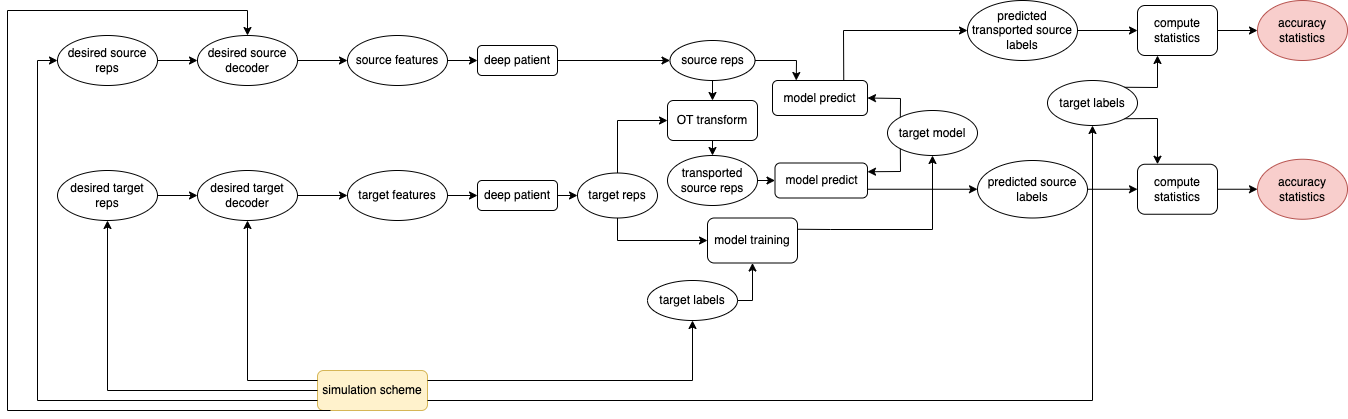

In [1]:
from IPython.display import Image
Image(filename='../outputs/EHR_emb_sim_pipeline.png')

In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")

from common import *
from math import floor, exp
import matplotlib.pylab as pl
import numpy as np
from numpy.random import poisson
import theano.tensor as T
from sklearn import linear_model


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def sample_embeddings(l, num_patient):
    """ 
    Sample embeddings from multivariate normal distribution

    :param int l: embedding dimension
    :param int num_patient: number of patient per domain

    returns two embeddings, one for source and one for target
    """

    def gen_spd_matrix(n):
        """ 
        Generate symmetric, positive definite matrix of dimension n
        """
        spd = np.random.random((n, n))
        spd = np.matmul(spd, np.transpose(spd))
        spd += n*np.identity(n)
        return spd
    
    def positive_emb(embedding):
        """ 
        Transform the embedding to all positives
        """
        for i in range(embedding.shape[0]):
            for j in range(embedding.shape[1]):
                embedding[i][j] = abs(embedding[i][j])
        return embedding

    mu_1 = np.random.uniform(size=l)
    Sigma_1 = gen_spd_matrix(l)
    E_1 = np.random.multivariate_normal(mu_1, Sigma_1, size=num_patient)
    E_1 = positive_emb(E_1)

    mu_2 = np.random.uniform(size=l)
    Sigma_2 = gen_spd_matrix(l)
    # E_2 = np.random.multivariate_normal(mu_2, Sigma_2, size=num_patient)
    E_2 = []
    for i in range(num_patient):
        E_2.append(np.random.uniform(size=l))
    E_2 = np.array(E_2)
    E_2 = positive_emb(E_2)

    return E_1, E_2



In [3]:
def sample_vae_params(l, feature_len):
    """ 
    Sample deep patient parameters necessary for reconstructing the data \
        from the representation per domain
    
    :param int l: the embedding dimension
    :param int feature_len: the feature cardinality 

    return 
        - wp, dimension is l x (# of visible units) (see da.py)
        - bp, dimension is 1 x (# of visible units) (see da.py)
    """
    wp = np.random.uniform(low=-0.5, high=0.5, size=[l, feature_len])
    bp = np.random.uniform(size=[1, feature_len])
    return wp, bp
    

In [4]:
def gen_features(wp, bp, embeddings):
    """ 
    Generate features based on embeddings, including
    - transform
    - denormalize
    """
    normalized_features = T.nnet.sigmoid(T.dot(embeddings, wp) + bp).eval()
    print("normalized_feature is:", normalized_features)
    denormalized_features = np.empty(shape=normalized_features.shape)

    sigma = 20 # TODO: can also simulate this parameter
    for i in range(len(normalized_features)):
        denormalized_features[i] = [feature*sigma for feature in normalized_features[i]]

    normalized_min = normalized_features.min()
    normalized_incre = 0
    if normalized_min < 0:
        normalized_incre = -normalized_min
    for i in range(len(denormalized_features)):
        denormalized_features[i] = [int(feature+normalized_incre) for feature in denormalized_features[i]]

    return denormalized_features

In [5]:
def sim_weight(D):
    W = np.random.normal(size=D) # sample weights
    W = [max(0, W_k) for W_k in W] # only sample positive weights
    return W

In [6]:
def gen_labels(feature_list, W, D):
    """ 
    Generate labels for all features in a domain, according to simulation 2 scheme

    """

    def sigmoid(x):
        """ 
        Sigmoid function
        """
        return 1 / (1 + exp(-x))
    
    def feature2ind(features):
        """ 
        Convert features to feature vector (indicator vector), per patient

        :param list[int] features: features with the actual feature code

        return
            - list[int]: a feature vector encoded by feature indicators
        """
        ind_vector = np.zeros(D)
        for feature in features:
            ind_vector[int(feature)] = 1
        return ind_vector

    # D = int(feature_list.max()+1) # set D, the total number of features, to be the number of features exist in feature_list
    # print("D is:", D)
    num_patient = feature_list.shape[0]
    # W = np.random.normal(size=D) # sample weights
    # W = [max(0, W_k) for W_k in W] # only sample positive weights
    X = []
    Y = []

    for i in range(num_patient):
        X_i = feature2ind(feature_list[i])
        for k in range(len(X_i)):
            if X_i[k] > 0:
                X_i[k] = 1 # dominant effect
        X.append(X_i)
        lambda_i= np.sum(np.multiply(W, X_i))
        Y_i = poisson(lam = lambda_i)
        Y.append(Y_i)
    return Y

In [7]:
def simulate(l, num_patient, target_feature_len, source_feature_len):
    """ 
    Complete simulation process, including
    - simulate embeddings
    - generate features from embeddings
    - generate labels from features

    :param int l: embedding dimension
    :param int num_patient: number of patients per domain
    :param int target_feature_len: target feature (actual codes) length
    :param int source_feature len: source fature (actual codes) length

    returns
    - target representation
    - target features
    - target labels
    - source representation
    - source features
    - source labels
    """
    
    target_reps, source_reps = sample_embeddings(l, num_patient)

    target_wp, target_bp = sample_vae_params(l, target_feature_len)
    source_wp, source_bp = sample_vae_params(l, source_feature_len)
    target_features = gen_features(target_wp, target_bp, target_reps) # how to ensure the features lie in [D]
    source_features = gen_features(source_wp, source_bp, source_reps)
    D = int(target_features.max()+1)
    D = max(D, source_features.max()+1)
    W = sim_weight(D)
    target_labels = gen_labels(target_features, W, D)
    source_labels = gen_labels(source_features, W, D)
    return target_reps, target_features, target_labels, source_reps, source_features, source_labels



In [8]:
embedding_dim = 2
num_patient = 100
target_feature_len = 4
source_feature_len = 5
target_reps, target_features, target_labels, source_reps, source_features, source_labels = \
    simulate(embedding_dim, num_patient, target_feature_len, source_feature_len)

normalized_feature is: [[0.61389595 0.80749327 0.71585453 0.80624308]
 [0.70345288 0.80439293 0.77426029 0.79420884]
 [0.56690909 0.78323418 0.6768568  0.78475143]
 [0.38518114 0.86412596 0.57113849 0.88020342]
 [0.49483483 0.87324743 0.65779185 0.88275651]
 [0.53907099 0.89545576 0.69838117 0.90257727]
 [0.34133865 0.88252754 0.54351133 0.89999228]
 [0.70717335 0.74767579 0.76405026 0.73100671]
 [0.38184098 0.86918108 0.57077049 0.88521495]
 [0.54061281 0.81244067 0.66723222 0.81768342]
 [0.53363573 0.76757135 0.64897819 0.77139136]
 [0.56909677 0.7781673  0.67696927 0.77918254]
 [0.60720032 0.73528834 0.69254251 0.72938624]
 [0.65998759 0.79681274 0.74370754 0.79037634]
 [0.61908674 0.74349658 0.70276885 0.73691516]
 [0.73813641 0.82459006 0.80164688 0.81294958]
 [0.52682221 0.87683823 0.6815216  0.88456065]
 [0.69179444 0.77603574 0.7598636  0.76421786]
 [0.52207411 0.83124076 0.66049627 0.83853896]
 [0.58230171 0.74458751 0.67738367 0.74209436]
 [0.72839591 0.8637573  0.80579774 0.

In [9]:
target_features, target_labels, source_features, source_labels

(array([[12., 16., 14., 16.],
        [14., 16., 15., 15.],
        [11., 15., 13., 15.],
        [ 7., 17., 11., 17.],
        [ 9., 17., 13., 17.],
        [10., 17., 13., 18.],
        [ 6., 17., 10., 17.],
        [14., 14., 15., 14.],
        [ 7., 17., 11., 17.],
        [10., 16., 13., 16.],
        [10., 15., 12., 15.],
        [11., 15., 13., 15.],
        [12., 14., 13., 14.],
        [13., 15., 14., 15.],
        [12., 14., 14., 14.],
        [14., 16., 16., 16.],
        [10., 17., 13., 17.],
        [13., 15., 15., 15.],
        [10., 16., 13., 16.],
        [11., 14., 13., 14.],
        [14., 17., 16., 17.],
        [14., 15., 15., 15.],
        [11., 17., 14., 17.],
        [11., 15., 13., 15.],
        [12., 17., 14., 17.],
        [14., 16., 15., 16.],
        [ 9., 17., 13., 17.],
        [ 9., 17., 12., 18.],
        [13., 15., 15., 15.],
        [ 8., 16., 11., 16.],
        [10., 15., 13., 15.],
        [14., 15., 15., 14.],
        [12., 17., 15., 17.],
        [1

In [10]:

def entire_proc_embedding_ordered(embedding_dim, num_patient, target_feature_len, source_feature_len, model_func):
    """ 
    Benchmark procedures for one simulation (one iteration)
        - Simulate target and source embeddings (aka. representations)
        - Generate the transported source embedding
        - Generate features and labels based on the embeddings
        - Train model using target representations and target labels
        - Using the trained model, compute statistics for 
            (1) target representations and target labels 
            (2) source representations and source labels
            (3) transported source representations and source labels
            and compare 
    
    :param int embedding_dim: the embedding dimension for the patient representations
    :param int num_patient: number of patients
    :param int target_feature_len: the length of target features per patient
    :param int source_feature_len: the length of source features per patient
    :paran function model_func: the function to model the relationship bewteen representations and labels

    returns the accuracy statistics (mae, mse and rmse)

    """
    target_reps, target_features, target_labels, source_reps, source_features, source_labels = \
        simulate(embedding_dim, num_patient, target_feature_len, source_feature_len)
    trans_source_reps = trans_source2target(source_reps, target_reps)
    target_mae, target_mse, target_rmse, source_mae, source_mse, source_rmse, \
        trans_source_mae, trans_source_mse, trans_source_rmse = \
        cal_stats_cts(target_reps, target_labels, source_reps, source_labels, trans_source_reps, model_func)
    vis_embedding(target_reps, source_reps, trans_source_reps)
    return target_mae, target_mse, target_rmse, source_mae, source_mse, source_rmse, \
        trans_source_mae, trans_source_mse, trans_source_rmse

    

In [11]:
def vis_embedding(target_reps, source_reps, trans_source_reps):
    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 1)
    pl.scatter(source_reps[:, 0], source_reps[:, 1], marker='o')
    pl.xticks([])
    pl.yticks([])
    # pl.legend(loc=0)
    pl.title('Source samples')

    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 2)
    pl.scatter(target_reps[:, 0], target_reps[:, 1], marker='+')
    pl.xticks([])
    pl.yticks([])
    # pl.legend(loc=0)
    pl.title('Target  samples')

    pl.figure(1, figsize=(15, 5))
    pl.subplot(1, 3, 3)
    pl.scatter(trans_source_reps[:, 0], trans_source_reps[:, 1], marker='o')
    pl.xticks([])
    pl.yticks([])
    # pl.legend(loc=0)
    pl.title('Transported samples')
    pl.tight_layout()
    pl.show()

normalized_feature is: [[0.88859648 0.8765174  0.81798571 0.74747579 0.36765295 0.66252509]
 [0.95580929 0.94407853 0.90581663 0.76448132 0.29956147 0.66892669]
 [0.88131079 0.86310221 0.79623471 0.83933159 0.40181369 0.56651331]
 [0.87189288 0.85057268 0.81509641 0.57684647 0.41240763 0.58013168]
 [0.8532419  0.82009367 0.79354625 0.59199132 0.46494325 0.45738973]
 [0.93552587 0.90495138 0.87725517 0.72602521 0.42596642 0.36618455]
 [0.76647559 0.76328195 0.69415037 0.7380873  0.44178406 0.63267914]
 [0.8879271  0.8753045  0.82843937 0.63123445 0.36728366 0.67468064]
 [0.87866404 0.84503825 0.81742563 0.62062332 0.45423849 0.43921942]
 [0.7974906  0.77157002 0.72618249 0.70649825 0.4798566  0.48748606]
 [0.85846    0.85319972 0.79204483 0.68383817 0.36867945 0.71586853]
 [0.96443339 0.93972101 0.92233744 0.68754851 0.4009791  0.31588771]
 [0.92518389 0.90444551 0.85704082 0.80321501 0.37937328 0.5305836 ]
 [0.84726765 0.82033879 0.79018662 0.56955263 0.4478498  0.5197399 ]
 [0.8023634

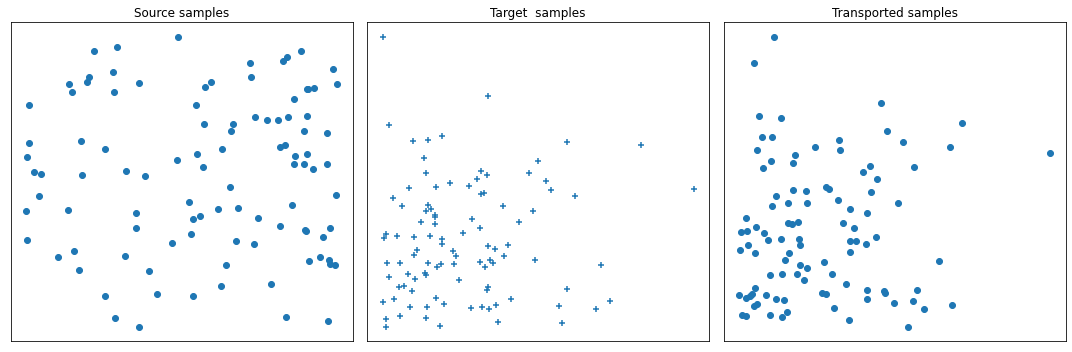

(0.7563270041903225,
 1.1194175096569656,
 1.05802528781545,
 0.4404022572002529,
 0.4980037789736,
 0.7056938280682352,
 0.6985339175208916,
 0.7570494318708928,
 0.87008587614723)

In [13]:
embedding_dim = 3
num_patient = 100
target_feature_len = 6
source_feature_len = 6
entire_proc_embedding_ordered(embedding_dim, num_patient, target_feature_len, source_feature_len, linear_model.LinearRegression)